## Import Pacakge

In [1]:
import gc
import psutil
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import storage
from google.api_core import exceptions
from google.cloud.aiplatform import matching_engine
from google.cloud.aiplatform.matching_engine import matching_engine_index_config
from google.cloud.aiplatform_v1.types import index_endpoint as index_endpoint_pb2
from google.cloud.aiplatform_v1.types import index as index_pb2
from pandarallel import pandarallel
from tqdm.auto import tqdm
from collections import defaultdict
import pickle
import json
import uuid
import shutil
from datetime import datetime
import time
import io
from io import BytesIO
import os
import re
import functools
from datasets import load_dataset
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from typing import List, Optional, Tuple, Dict
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import faiss

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from rank_bm25 import BM25Okapi

from nltk.translate.bleu_score import sentence_bleu
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from PIL import Image
import PIL
from urllib.parse import urlparse, unquote
import logging
logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('image_processing_errors.log')
    ]
)
import requests
from concurrent.futures import ThreadPoolExecutor
import requests.exceptions

from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer, get_cosine_schedule_with_warmup, AutoModel, AutoProcessor, pipeline
import open_clip
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

from huggingface_hub import HfApi, login, hf_hub_download
HF_TOKEN = os.getenv('HUGGINGFACE_TOKEN', '')
import warnings
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Initialize parallel processing
pandarallel.initialize(progress_bar=True, nb_workers=15)

/opt/conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-12-08 14:38:54.669301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733668735.192032    3196 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugi

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 1. Initialize Google Cloud

In [2]:
aiplatform.init(
    project='adsp-genai-group1',
    location='us-central1'
)

In [3]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if device.type == 'cuda':
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    print(f'Memory Usage:')
    print(f'Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB')
    print(f'Cached: {round(torch.cuda.memory_cached(0)/1024**3,1)} GB')

Using device: cuda
GPU Name: Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


## 2. Load Amazon Product Data

In [4]:
amazon_df = pd.read_csv("amazon_data/amazon_data.csv")
amazon_df.head(2)

,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",NaN,NaN,Toys & Games | Learning & Education | Science ...,NaN,NaN,$99.95,NaN,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


In [5]:
amazon_df.columns

Index(['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category',
       'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity',
       'Model Number', 'About Product', 'Product Specification',
       'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image',
       'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details',
       'Dimensions', 'Color', 'Ingredients', 'Direction To Use',
       'Is Amazon Seller', 'Size Quantity Variant', 'Product Description'],
      dtype='object')

In [6]:
# Data Loading and Quality Checks
def load_and_validate_data(file_path):
    """Load and validate the Amazon product dataset with improved image handling"""
    df = pd.read_csv(file_path)
    required_columns = ["Uniq Id", "Product Name", "Category", "Selling Price", 
                       "Model Number", "About Product", "Product Specification", 
                       "Product Url", "Image"]
    
    missing_cols = set(required_columns) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    df = df[required_columns]
    
    # Process images and create a mapping of successful images
    processed_images = process_images_parallel(df)
    df['Processed Image'] = processed_images
    
    # Remove rows with invalid images
    valid_mask = df['Processed Image'].notna()
    invalid_count = (~valid_mask).sum()
    
    if invalid_count > 0:
        print(f"\nRemoved {invalid_count} records with invalid images")
        df = df[valid_mask]
    
    print("\nData Quality Report:")
    print(f"Total valid records: {len(df)}")
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    return df

## 3. Data Preprocessing

In [51]:
def process_image(image_urls, target_size=(224, 224)):
    """Process and validate individual images with improved error handling"""
    # Split URLs if multiple URLs are provided
    urls = image_urls.split('|') if '|' in image_urls else [image_urls]
    
    # Try each URL until we get a valid image
    for url in urls:
        try:
            # Clean and validate URL
            url = url.strip()
            url = unquote(url)  # URL decode
            
            # Skip transparent pixel images
            if 'transparent-pixel' in url:
                continue
                
            # Skip size chart images
            if any(x in url.lower() for x in ['sizechart', 'chart', 'quarterdeck']):
                continue
            
            # Validate URL format
            parsed_url = urlparse(url)
            if not all([parsed_url.scheme, parsed_url.netloc]):
                continue
            
            # Fetch image with increased timeout and proper headers
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }
            response = requests.get(url, timeout=30, headers=headers, allow_redirects=True)
            response.raise_for_status()
            
            # Attempt to open image with PIL
            image = Image.open(io.BytesIO(response.content))
            
            # Convert RGBA images to RGB
            if image.mode == 'RGBA':
                image = image.convert('RGB')
            elif image.mode not in ['RGB', 'L']:
                image = image.convert('RGB')
            
            # Resize image
            image = image.resize(target_size, Image.LANCZOS)
            
            # Validate image size
            if image.size[0] < 100 or image.size[1] < 100:
                continue
            
            return image
            
        except requests.exceptions.RequestException:
            continue
        except ValueError:
            continue
        except Image.UnidentifiedImageError:
            continue
        except Exception as e:
            continue

In [9]:
def process_images_parallel(df, num_workers=15):
    """Process images in parallel"""
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        processed_images = list(executor.map(process_image, df['Image']))
    return processed_images

In [10]:
def normalize_text(text):
    """Normalize text while preserving important information"""
    # Define fields and phrases to preserve exactly
    preserve_fields = {
        'Uniq Id', 'Price', 'Model', 'Product Url', 'Category', 'ASIN', 'Unavailable Price', 
        'Model Number Not Available', 'No Product Description Available',
        'No Specifications Available', 'Unknown Category', 'No URL Available',
        'Item model number', 'Product Dimensions', 'Shipping Weight'
    }
    
    # Define status messages to preserve exactly
    status_messages = {
        'Unavailable Price',
        'Model Number Not Available',
        'No Product Description Available',
        'No Specifications Available',
        'Unknown Category',
        'No URL Available'
    }
    
    # Define product-specific terms to preserve
    product_terms = {
        'FM Radio', 'HD', 'USB', '3D', 'LED', 'LCD', 'DVD', 'TV', 'AC',
        'inches', 'pounds', 'lbs', 'cm', 'mm', 'ml', 'oz', 'MHz', 'GB', 
        'TB', 'MP', 'WiFi', 'Bluetooth'
    }
    
    sections = text.split(' | ')
    normalized_sections = []
    
    for section in sections:
        if ':' in section:
            header, content = section.split(':', 1)
            header = header.strip()
            content = content.strip()
            
            # Preserve headers and status messages exactly
            if header in preserve_fields or content in status_messages:
                normalized_sections.append(f"{header}: {content}")
                continue
            
            # Preserve product identifiers
            if re.search(r'(ASIN:|#\d+\sin\s|Item model number:)', content):
                normalized_sections.append(f"{header}: {content}")
                continue
            
            # Preserve measurements and specifications
            if any(term in content for term in product_terms):
                normalized_sections.append(f"{header}: {content}")
                continue
            
            # Preserve prices and numbers
            if re.search(r'[\d$]', content):
                normalized_sections.append(f"{header}: {content}")
                continue
            
            # Normalize other content while preserving structure
            tokens = word_tokenize(content.lower())
            stop_words = set(stopwords.words('english'))
            tokens = [token for token in tokens if (
                token not in stop_words or 
                token.isnumeric() or 
                any(char.isdigit() for char in token) or
                token in product_terms
            )]
            
            lemmatizer = WordNetLemmatizer()
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
            normalized_sections.append(f"{header}: {' '.join(lemmatized_tokens)}")
        else:
            normalized_sections.append(section)
    
    return ' | '.join(normalized_sections)

In [11]:
def clean_product_data(df):
    """Clean and standardize product data"""
    def clean_price(x):
        """Clean and standardize price values"""
        if pd.isna(x):
            return 'Unavailable Price'
        try:
            if isinstance(x, (int, float)):
                return float(x)
            # Remove currency symbols and commas
            cleaned = str(x).replace('$', '').replace(',', '').strip()
            if '-' in cleaned:  # Handle price ranges
                first_price = cleaned.split('-')[0].strip()
                return float(first_price)
            numbers = re.findall(r'\d+\.?\d*', cleaned)
            if not numbers:
                return 'Unavailable Price'
            return float(numbers[0])
        except (ValueError, TypeError):
            return 'Unavailable Price'
    
    def clean_category(x):
        if pd.isna(x):
            return 'Unknown Category'
        categories = [cat.strip().lower() for cat in str(x).split('|')]
        return ' > '.join(filter(None, categories))
    
    def clean_model_number(x):
        if pd.isna(x) or not str(x).strip():
            return 'Model Number Not Available'
        return str(x).strip().upper()
    
    def clean_specification_text(x):
        if pd.isna(x):
            return 'No Specifications Available'
        text = re.sub(r'\s+', ' ', str(x))
        specs = [s.strip() for s in re.split(r'[|;]', text) if s.strip()]
        specs = list(dict.fromkeys(specs))
        return ' | '.join(specs)
    
    def clean_about_product_text(x):
        if pd.isna(x):
            return 'No Product Description Available'
        text = re.sub(r'Make sure this fits by entering your model number\.\s*\|?\s*', '', str(x))
        features = [f.strip() for f in text.split('|') if f.strip()]
        features = list(dict.fromkeys(features))
        return ' | '.join(features)
    
    def clean_product_name(x):
        if pd.isna(x):
            return 'Unknown Product'
        return re.sub(r'\s+', ' ', str(x).strip())
    
    def clean_url(x):
        if pd.isna(x) or not str(x).strip():
            return 'No URL Available'
        return str(x).strip()
    
    # Define status messages to preserve
    status_messages = {
        'Unavailable Price',
        'Model Number Not Available',
        'No Product Description Available',
        'No Specifications Available',
        'Unknown Category',
        'No URL Available'
    }

    def clean_text(x):
        # Preserve status messages
        if any(status in str(x) for status in status_messages):
            return x
        # Preserve product identifiers
        if re.search(r'(Item model number:|ASIN:|#\d+\sin\s)', str(x)):
            return x
        return re.sub(r'[^\w\s|>$&(),.;:\-+#@/]', '', str(x))

    # Apply cleaning functions
    df['Product Name'] = df['Product Name'].apply(clean_product_name)
    df['Category'] = df['Category'].apply(clean_category)
    df['Selling Price'] = df['Selling Price'].apply(clean_price)
    df['Model Number'] = df['Model Number'].apply(clean_model_number)
    df['About Product'] = df['About Product'].apply(clean_about_product_text)
    df['Product Specification'] = df['Product Specification'].apply(clean_specification_text)
    df['Product Url'] = df['Product Url'].apply(clean_url)
    
    # Clean text columns while preserving important information
    text_columns = ['Product Name', 'Category','Selling Price', 'Model Number', 
                    'About Product', 'Product Specification']
    for col in text_columns:
        df[col] = df[col].apply(clean_text)
    
    return df

In [12]:
# Enhanced product description creation
def create_product_description(row):
    """Create comprehensive product description"""
    desc_parts = []
    
    desc_parts.append(f"Uniq Id: {row['Uniq Id']}")
    desc_parts.append(f"Product: {row['Product Name']}")
    
    if row['Category'] != 'Unknown Category':
        desc_parts.append(f"Category: {row['Category']}")
    
    # Handle price formatting
    if isinstance(row['Selling Price'], (int, float)):
        desc_parts.append(f"Price: ${row['Selling Price']:.2f}")
    else:
        desc_parts.append(f"Price: {row['Selling Price']}")
    
    if row['Model Number'] != 'Model Number Not Available':
        desc_parts.append(f"Model: {row['Model Number']}")
    
    if row['About Product'] != 'No Product Description Available':
        desc_parts.append(f"Description: {row['About Product']}")
    
    if row['Product Specification'] != 'No Specifications Available':
        desc_parts.append(f"Specifications: {row['Product Specification']}")
    
    desc_parts.append(f"Product Url: {row['Product Url']}")
    
    return ' | '.join(desc_parts)

In [13]:
amazon_df = load_and_validate_data("amazon_data/amazon_data.csv")


Removed 22 records with invalid images

Data Quality Report:
Total valid records: 9980

Missing values per column:
Uniq Id                     0
Product Name                0
Category                  829
Selling Price             107
Model Number             1751
About Product             273
Product Specification    1611
Product Url                 0
Image                       0
Processed Image             0
dtype: int64


In [14]:
amazon_df = clean_product_data(amazon_df)
amazon_df['Product Description'] = amazon_df.apply(create_product_description, axis=1)
amazon_df['Normalized Description'] = amazon_df['Product Description'].apply(normalize_text)

In [15]:
amazon_df.columns

Index(['Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number',
       'About Product', 'Product Specification', 'Product Url', 'Image',
       'Processed Image', 'Product Description', 'Normalized Description'],
      dtype='object')

In [16]:
amazon_df[['Category', "Model Number", 'Product Description', 'Normalized Description']].head(2)

,Category,Model Number,Product Description,Normalized Description
0,sports & outdoors > outdoor recreation > skate...,Model Number Not Available,Uniq Id: 4c69b61db1fc16e7013b43fc926e502d | Pr...,Uniq Id: 4c69b61db1fc16e7013b43fc926e502d | Pr...
1,toys & games > learning & education > science ...,55324,Uniq Id: 66d49bbed043f5be260fa9f7fbff5957 | Pr...,Uniq Id: 66d49bbed043f5be260fa9f7fbff5957 | Pr...


##### Save the cleaned data on Hugging Face

In [17]:
def save_cleaned_data_to_hf(df, repo_id, token):
    """Save cleaned data to HuggingFace as parquet"""
    # Create a copy of the dataframe
    df_to_save = df.copy()
    
    # Convert PIL images to bytes
    def image_to_bytes(img):
        if isinstance(img, PIL.Image.Image):
            buffer = io.BytesIO()
            img.save(buffer, format='PNG')
            return buffer.getvalue()
        return None
    
    # Convert the Processed Image column
    df_to_save['Processed Image'] = df_to_save['Processed Image'].apply(image_to_bytes)
    
    # Login to Hugging Face
    login(token=token)
    api = HfApi()
    
    # Create temporary directory
    os.makedirs('cleaned_data', exist_ok=True)
    
    # Save as parquet with compression
    parquet_path = 'cleaned_data/amazon_cleaned.parquet'
    df_to_save.to_parquet(
        parquet_path,
        compression='snappy',
        index=False
    )
    
    # Create README
    readme_content = """
    # Amazon Product 2020 Cleaned Dataset

    This dataset contains cleaned and preprocessed Amazon product data with:
    - Normalized text descriptions
    - Processed images (stored as PNG bytes)
    - Standardized categories and prices
    - Cleaned product specifications
    
    ## Columns
    - Uniq Id: Unique identifier for each product
    - Product Name: Cleaned product names
    - Category: Standardized category hierarchy
    - Selling Price: Normalized price values
    - Model Number: Standardized model numbers
    - About Product: Cleaned product descriptions
    - Product Specification: Normalized specifications
    - Product Url: Valid product URLs
    - Processed Image: PNG image bytes
    - Product Description: Combined product information
    - Normalized Description: Lemmatized and normalized text
    """
    
    with open("cleaned_data/README.md", "w") as f:
        f.write(readme_content)
    
    # Upload to HuggingFace
    api.upload_folder(
        folder_path="cleaned_data",
        repo_id=repo_id,
        repo_type="dataset"
    )
    
    # Cleanup
    shutil.rmtree('cleaned_data')
    print(f"Cleaned data pushed to: https://huggingface.co/datasets/{repo_id}")

In [18]:
# Save the cleaned data
save_cleaned_data_to_hf(
    df=amazon_df,
    repo_id="chen196473/amazon_product_2020_cleaned",
    token=HF_TOKEN
)

amazon_cleaned.parquet:   0%|          | 0.00/580M [00:00<?, ?B/s]

Cleaned data pushed to: https://huggingface.co/datasets/chen196473/amazon_product_2020_cleaned


In [19]:
pd.set_option('display.max_colwidth', None)

In [21]:
# Load the dataset
dataset = load_dataset("chen196473/amazon_product_2020_cleaned")

# Convert to pandas DataFrame if needed
cleaned_df = dataset['train'].to_pandas()

cleaned_df[['Product Description', 'Normalized Description']].head(2)

Repo card metadata block was not found. Setting CardData to empty.
2024-12-04 23:33:58,760 - WARNING - Repo card metadata block was not found. Setting CardData to empty.


amazon_cleaned.parquet:   0%|          | 0.00/580M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

,Product Description,Normalized Description
0,"Uniq Id: 4c69b61db1fc16e7013b43fc926e502d | Product: DB Longboards CoreFlex Crossbow 41 Bamboo Fiberglass Longboard Complete | Category: sports & outdoors > outdoor recreation > skates, skateboards & scooters > skateboarding > standard skateboards & longboards > longboards | Price: 237.68 | Description: RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern thats second to none. Pumping & carving have never been so satisfying Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you wont believe. These boards combine fiberglass, epoxy, HD plastic and bamboo to create a perfect blend of performance and strength. | INSPIRED BY THE NORTHWEST: Our founding ideal is chasing adventure & riding the best boards possible, inspired by the hills, waves, beaches & mountains all around our headquarters in the Northwest | BEST IN THE WORLD: DB was founded out of sheer love of longboarding with a mission to create the best custom longboards in the world, to do it sustainably, & to treat customers & employees like family | BEYOND COMPARE: Try our skateboards & accessories if youve tried similar products by Sector 9, Landyachtz, Arbor, Loaded, Globe, Orangatang, Hawgs, Powell-Peralta, Blood Orange, Caliber or Gullwing | Specifications: Shipping Weight: 10.7 pounds (View shipping rates and policies) | ASIN: B07KMVJJK7 | #474 in Longboards Skateboard | Product Url: https://www.amazon.com/DB-Longboards-CoreFlex-Fiberglass-Longboard/dp/B07KMVJJK7","Uniq Id: 4c69b61db1fc16e7013b43fc926e502d | Product: DB Longboards CoreFlex Crossbow 41 Bamboo Fiberglass Longboard Complete | Category: sports & outdoors > outdoor recreation > skates, skateboards & scooters > skateboarding > standard skateboards & longboards > longboards | Price: 237.68 | Description: RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern thats second to none. Pumping & carving have never been so satisfying Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you wont believe. These boards combine fiberglass, epoxy, HD plastic and bamboo to create a perfect blend of performance and strength. | INSPIRED BY THE NORTHWEST: founding ideal chasing adventure & riding best board possible , inspired hill , wave , beach & mountain around headquarters northwest | BEST IN THE WORLD: db founded sheer love longboarding mission create best custom longboards world , sustainably , & treat customer & employee like family | BEYOND COMPARE: Try our skateboards & accessories if youve tried similar products by Sector 9, Landyachtz, Arbor, Loaded, Globe, Orangatang, Hawgs, Powell-Peralta, Blood Orange, Caliber or Gullwing | Specifications: Shipping Weight: 10.7 pounds (View shipping rates and policies) | ASIN: B07KMVJJK7 | #474 in Longboards Skateboard | Product Url: https://www.amazon.com/DB-Longboards-CoreFlex-Fiberglass-Longboard/dp/B07KMVJJK7"
1,"Uniq Id: 66d49bbed043f5be260fa9f7fbff5957 | Product: Electronic Snap Circuits Mini Kits Classpack, FM Radio, Motion Detector, Music Box (Set of 5) | Category: toys & games > learning & education > science kits & toys | Price: 99.95 | Model: 55324 | Description: Snap circuits mini kits classpack provides basic electronic circuitry activities for students in grades 2-6 | Includes 5 separate mini building kits- an FM radio, a motion detector, music box, space battle sound effects, and a flying saucer | Each kit includes separate components and instructions to build | Each component represents one function in a circuit; components snap together to create working models of everyday electronic devices | Activity guide provides additional projects to te

#### Create the Metadata

In [37]:
def parse_price(price):
    """Parse and normalize price values"""
    if pd.isna(price):
        return 0.0
    if price == 'Unavailable Price':
        return 0.0
    try:
        if isinstance(price, (int, float)):
            return float(price)
        cleaned = str(price).replace('$', '').replace(',', '').strip()
        if '-' in cleaned:
            first_price = cleaned.split('-')[0].strip()
            return float(first_price)
        numbers = re.findall(r'\d+\.?\d*', cleaned)
        if not numbers:
            return 0.0
        return float(numbers[0])
    except (ValueError, TypeError):
        return 0.0

def extract_key_terms(text):
    """Extract key terms from product description"""
    if pd.isna(text):
        return []
    
    # Remove special characters and split
    cleaned_text = re.sub(r'[^\w\s|]', ' ', str(text))
    terms = cleaned_text.lower().split()
    
    # Remove common words and numbers
    stop_words = set(['the', 'and', 'or', 'in', 'at', 'on', 'with', 'by', 
                     'from', 'to', 'for', 'of', 'this', 'that', 'these', 
                     'those', 'is', 'are', 'was', 'were'])
    terms = [term for term in terms if term not in stop_words and not term.isdigit()]
    
    return terms

def extract_brand(product_name):
    """Extract brand name from product name"""
    if pd.isna(product_name):
        return None
        
    # Known brands dictionary with aliases
    known_brands = {
        'google': ['nest', 'google home', 'google nest'],
        'amazon': ['echo', 'alexa', 'amazon echo', 'kindle'],
        'apple': ['iphone', 'ipad', 'macbook', 'airpods'],
        'samsung': ['galaxy', 'samsung gear'],
        'microsoft': ['xbox', 'surface'],
        'sony': ['playstation', 'ps4', 'ps5'],
        'db': ['db longboards'],
        '3doodler': ['3d printing']
    }
    
    name_lower = product_name.lower()
    
    # Check for known brands and their aliases
    for brand, aliases in known_brands.items():
        if brand in name_lower or any(alias in name_lower for alias in aliases):
            return brand
    
    # Remove common prefixes
    brand_prefixes = ['by ', 'from ', 'made by ']
    name = name_lower
    for prefix in brand_prefixes:
        if prefix in name:
            name = name.split(prefix)[1]
    
    # Take first word unless it's a number or common word
    words = name.split()
    if words:
        first_word = words[0]
        if not first_word.isdigit() and first_word not in {'the', 'a', 'an'}:
            return first_word
    
    return None

def create_category_aliases():
    """Create comprehensive category aliases mapping"""
    return {
        'smart speaker': ['smart home', 'speaker', 'voice assistant', 'home automation', 
                         'alexa', 'google home', 'nest', 'echo'],
        'wireless earbuds': ['headphones', 'earphones', 'audio', 'airpods', 'buds', 
                            'wireless audio'],
        'smart display': ['smart home', 'display', 'screen', 'echo show', 'nest hub', 
                         'smart screen'],
        'electronics': ['tech', 'gadget', 'device', 'electronic', 'accessories', 
                       'charger', 'cable'],
        'longboard': ['skateboard', 'board', 'outdoor', 'skate', 'cruiser', 
                     'skateboarding'],
        'toys': ['game', 'play', 'educational', 'kids', 'children', 'learning', 
                'toy', 'games'],
        'computer': ['laptop', 'desktop', 'pc', 'computing', 'monitor', 'keyboard', 
                    'mouse'],
        'camera': ['digital camera', 'dslr', 'mirrorless', 'photography', 'lens', 
                  'photo'],
        'phone': ['smartphone', 'mobile', 'cell phone', 'iphone', 'android', 
                 'mobile phone']
    }

def create_product_metadata(row):
    """Enhanced metadata creation with advanced data validation and normalization"""
    category_aliases = create_category_aliases()
    
    def normalize_metadata_text(text, category_aliases):
        if pd.isna(text):
            return ''
        
        normalized_text = str(text).lower()
        # Add category context
        for main_category, aliases in category_aliases.items():
            if any(alias in normalized_text for alias in aliases):
                normalized_text = f"{normalized_text} {main_category}"
        
        return re.sub(r'[^\w\s|>$&(),.;:\-+#@/]', '', normalized_text).strip()
    
    # Generate comprehensive keywords
    keywords = set()
    keywords.update(row['Product Name'].lower().split())
    if not pd.isna(row['Category']):
        categories = row['Category'].lower().split(' > ')
        for i, category in enumerate(categories):
            keywords.update(category.split())
            keywords.add(' > '.join(categories[:i+1]))
    
    # Add model number variations
    if row['Model Number'] != 'Model Number Not Available':
        model = row['Model Number'].lower()
        keywords.add(model)
        keywords.add(re.sub(r'[^\w]', '', model))
    
    # Add price range indicators
    price = parse_price(row['Selling Price'])
    if price > 0:
        price_range = f"price_{(price // 50) * 50}_{((price // 50) + 1) * 50}"
        keywords.add(price_range)
    
    # Create optimized search text
    search_text = [
        row['Product Name'].lower(),
        row['Category'].lower() if not pd.isna(row['Category']) else '',
        row['Model Number'].lower() if row['Model Number'] != 'Model Number Not Available' else ''
    ]
    
    if 'About Product' in row and not pd.isna(row['About Product']):
        search_text.extend(extract_key_terms(row['About Product']))
    
    metadata = {
        'Uniq_Id': row['Uniq Id'],
        'Product_Name': normalize_metadata_text(row['Product Name'], category_aliases),
        'Category': normalize_metadata_text(row['Category'], category_aliases),
        'Selling_Price': parse_price(row['Selling Price']),
        'Model_Number': row['Model Number'],
        'Keywords': list(keywords),
        'Search_Text': ' '.join(filter(None, search_text)),
        'Image': row['Image'],
        'Has_Processed_Image': row['Processed Image'] is not None,
        'Image_Status': 'valid' if row['Processed Image'] is not None else 'invalid',
        'Has_Processed_Image': True if 'Processed Image' in row and row['Processed Image'] is not None else False,
        'Normalized_Description': row['Normalized Description'] if 'Normalized Description' in row else '',
        'Has_Valid_Image': row['Processed Image'] is not None,
        'Image_Status': 'valid' if row['Processed Image'] is not None else 'invalid'
    }
    
    return metadata

def create_metadata_index(df):
    """Create a comprehensive searchable metadata index"""
    from collections import defaultdict
    
    base_metadata = df.apply(create_product_metadata, axis=1).tolist()
    
    indices = {
        'base_metadata': base_metadata,
        'category_index': defaultdict(list),
        'price_range_index': defaultdict(list),
        'keyword_index': defaultdict(list),
        'brand_index': defaultdict(list),
        'product_name_index': defaultdict(list)  # Add product name index
    }
    
    for meta in base_metadata:
        # Index all keywords
        for keyword in meta['Keywords']:
            indices['keyword_index'][keyword].append(meta['Uniq_Id'])
        
        # Index categories with hierarchy
        categories = meta['Category'].split(' > ')
        for i, category in enumerate(categories):
            indices['category_index'][category].append(meta['Uniq_Id'])
            indices['category_index'][' > '.join(categories[:i+1])].append(meta['Uniq_Id'])
        
        # Index price ranges with finer granularity
        price = meta['Selling_Price']
        for granularity in [50, 100, 500]:
            price_range = f"{(price // granularity) * granularity}-{((price // granularity) + 1) * granularity}"
            indices['price_range_index'][price_range].append(meta['Uniq_Id'])
        
        # Index brands with aliases
        brand = extract_brand(meta['Product_Name'])
        if brand:
            indices['brand_index'][brand].append(meta['Uniq_Id'])
            
        # Index product names
        product_name_words = meta['Product_Name'].lower().split()
        for word in product_name_words:
            indices['product_name_index'][word].append(meta['Uniq_Id'])
    
    return indices

In [38]:
def print_metadata_preview(metadata_index):
    """Print a preview of the metadata structure before uploading"""
    print("\n## Base Metadata Sample (First 3 Items)")
    for item in metadata_index['base_metadata'][:3]:
        print(f"\nProduct ID: {item['Uniq_Id']}")
        print(f"Name: {item['Product_Name']}")
        print(f"Category: {item['Category']}")
        print(f"Price: ${item['Selling_Price']:.2f}")
        print(f"Keywords: {', '.join(item['Keywords'][:5])}...")
        print("-" * 50)
    
    print("\n## Category Index Sample (First 3 Categories)")
    for i, (category, products) in enumerate(metadata_index['category_index'].items()):
        if i >= 3: break
        print(f"\nCategory: {category}")
        print(f"Product Count: {len(products)}")
        print(f"Sample Products: {', '.join(products[:3])}...")
        print("-" * 50)
    
    print("\n## Keyword Index Sample (First 3 Keywords)")
    for i, (keyword, products) in enumerate(metadata_index['keyword_index'].items()):
        if i >= 3: break
        print(f"\nKeyword: {keyword}")
        print(f"Product Count: {len(products)}")
        print(f"Sample Products: {', '.join(products[:3])}...")
        print("-" * 50)
    
    print("\n## Brand Index Sample (First 3 Brands)")
    for i, (brand, products) in enumerate(metadata_index['brand_index'].items()):
        if i >= 3: break
        print(f"\nBrand: {brand}")
        print(f"Product Count: {len(products)}")
        print(f"Sample Products: {', '.join(products[:3])}...")
        print("-" * 50)
        
    print("\n## Image Status Statistics")
    valid_images = sum(1 for item in metadata_index['base_metadata'] 
                      if item.get('Has_Valid_Image', False))
    total_items = len(metadata_index['base_metadata'])
    print(f"Valid Images: {valid_images}/{total_items} ({valid_images/total_items*100:.2f}%)")
    
    # Print statistics
    print("\n## Metadata Statistics")
    print(f"Total Products: {len(metadata_index['base_metadata'])}")
    print(f"Total Categories: {len(metadata_index['category_index'])}")
    print(f"Total Keywords: {len(metadata_index['keyword_index'])}")
    print(f"Total Brands: {len(metadata_index['brand_index'])}")
    print(f"Total Product Name Indexs: {len(metadata_index['product_name_index'])}")
    

def validate_metadata(metadata_index):
    """Enhanced metadata validation"""
    validation_results = {
        'errors': [],
        'warnings': []
    }
    
    # Check image alignment
    image_count = sum(1 for item in metadata_index['base_metadata'] 
                     if item.get('Has_Valid_Image', False))
    if image_count != len(metadata_index['base_metadata']):
        validation_results['warnings'].append(
            f"Image misalignment: {image_count} valid images for "
            f"{len(metadata_index['base_metadata'])} products"
        )
    
    # Check required fields
    required_fields = ['base_metadata', 'category_index', 'keyword_index', 'brand_index', 'product_name_index']
    for field in required_fields:
        if field not in metadata_index:
            validation_results['errors'].append(f"Missing required field: {field}")
    
    # Validate base metadata
    for item in metadata_index['base_metadata']:
        if 'Uniq_Id' not in item:
            validation_results['errors'].append(f"Missing Uniq_Id in product metadata")
        if 'Keywords' not in item:
            validation_results['warnings'].append(f"Missing Keywords for product {item.get('Uniq_Id', 'Unknown')}")
    
    return validation_results

# Usage example:
if __name__ == "__main__":
    # Create metadata index
    metadata_index = create_metadata_index(amazon_df)
    
    # Validate metadata
    validation_results = validate_metadata(metadata_index)
    
    # Print validation results
    if validation_results['errors']:
        print("\n## Validation Errors")
        for error in validation_results['errors']:
            print(f"- {error}")
    
    if validation_results['warnings']:
        print("\n## Validation Warnings")
        for warning in validation_results['warnings']:
            print(f"- {warning}")
    
    # Print metadata preview
    print_metadata_preview(metadata_index)


## Base Metadata Sample (First 3 Items)

Product ID: 4c69b61db1fc16e7013b43fc926e502d
Name: db longboards coreflex crossbow 41 bamboo fiberglass longboard complete longboard
Category: sports & outdoors > outdoor recreation > skates, skateboards & scooters > skateboarding > standard skateboards & longboards > longboards longboard
Price: $237.68
Keywords: &, sports, longboards, bamboo, crossbow...
--------------------------------------------------

Product ID: 66d49bbed043f5be260fa9f7fbff5957
Name: electronic snap circuits mini kits classpack, fm radio, motion detector, music box (set of 5) electronics
Category: toys & games > learning & education > science kits & toys toys
Price: $99.95
Keywords: &, (set, kits, fm, box...
--------------------------------------------------

Product ID: 2c55cae269aebf53838484b0d7dd931a
Name: 3doodler create flexy 3d printing filament refill bundle (x5 pack, over 1000. of extruded plastics - innovate
Category: toys & games > arts & crafts > craft kits toy

In [39]:
def save_metadata_index_to_hf(metadata_index, repo_id, token):
    """Save enhanced metadata index to HuggingFace"""
    # Login to Hugging Face
    login(token=token)
    api = HfApi()
    
    # Create the repository if it doesn't exist
    try:
        api.create_repo(
            repo_id=repo_id,
            repo_type="dataset",
            private=False,
            exist_ok=True
        )
    except Exception as e:
        print(f"Repository creation error: {e}")
        return
    
    # Create temporary directory
    os.makedirs('metadata_index', exist_ok=True)
    
    # Save each index component with proper handling of defaultdict
    for index_name, index_data in metadata_index.items():
        file_path = f'metadata_index/{index_name}.json'
        
        # Convert defaultdict to regular dict for JSON serialization
        if isinstance(index_data, defaultdict):
            index_data = dict(index_data)
        
        # Handle special cases for base_metadata
        if index_name == 'base_metadata':
            # Convert sets to lists in keywords
            for item in index_data:
                if 'Keywords' in item and isinstance(item['Keywords'], set):
                    item['Keywords'] = list(item['Keywords'])
        
        with open(file_path, 'w') as f:
            json.dump(index_data, f, indent=2)
    
    # Create enhanced README
    readme_content = """
    # Enhanced Amazon Product Metadata Index
    
    Comprehensive searchable index containing:
    - Base metadata for all products
    - Category hierarchy index with aliases
    - Price range index with multiple granularities
    - Keyword index with enhanced product terms
    - Brand index with known brand aliases
    
    Features:
    - Improved category matching
    - Better brand recognition
    - Enhanced keyword generation
    - Multiple price range granularities
    - Normalized text descriptions
    
    Use for advanced product search and filtering capabilities.
    """
    
    with open("metadata_index/README.md", "w") as f:
        f.write(readme_content)
    
    # Create metadata schema documentation
    schema_content = """
    # Metadata Schema
    
    ## Base Metadata
    - Uniq_Id: Unique product identifier
    - Product_Name: Normalized product name
    - Category: Hierarchical category path
    - Selling_Price: Normalized price value
    - Model_Number: Product model number
    - Keywords: Enhanced keyword list
    - Search_Text: Optimized search text
    - Image: Product image URL
    - Has_Processed_Image: Image processing status
    - Normalized_Description: Cleaned product description
    
    ## Indices
    - category_index: Category-based lookup
    - price_range_index: Multi-granular price ranges
    - keyword_index: Enhanced keyword mapping
    - brand_index: Brand recognition with aliases
    """
    
    with open("metadata_index/SCHEMA.md", "w") as f:
        f.write(schema_content)
    
    try:
        # Upload to HuggingFace
        api.upload_folder(
            folder_path="metadata_index",
            repo_id=repo_id,
            repo_type="dataset"
        )
        print(f"Enhanced metadata index pushed to: https://huggingface.co/datasets/{repo_id}")
    except Exception as e:
        print(f"Upload error: {e}")
    finally:
        # Cleanup
        shutil.rmtree('metadata_index')

In [40]:
# Create and save metadata index
metadata_index = create_metadata_index(amazon_df)
save_metadata_index_to_hf(
    metadata_index=metadata_index,
    repo_id="chen196473/amazon_product_2020_metadata",
    token=HF_TOKEN
)

No files have been modified since last commit. Skipping to prevent empty commit.
2024-12-04 23:58:57,444 - WARNING - No files have been modified since last commit. Skipping to prevent empty commit.


Enhanced metadata index pushed to: https://huggingface.co/datasets/chen196473/amazon_product_2020_metadata


## 4. Generate Embeddings

In [41]:
try:
    model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:Marqo/marqo-fashionCLIP')
    model = model.to(device)
    tokenizer = open_clip.get_tokenizer('hf-hub:Marqo/marqo-fashionCLIP')
except Exception as e:
    print(f"Error loading FashionCLIP model: {e}")
    raise

In [42]:
def generate_embeddings_batch(texts, images, batch_size=16):
    """Generate embeddings with improved error handling and alignment"""
    text_embeddings = []
    image_embeddings = []
    valid_indices = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        batch_images = images[i:i + batch_size]
        
        # Process text embeddings
        try:
            text_tokens = tokenizer(batch_texts).to(device)
            with torch.no_grad():
                batch_text_features = model.encode_text(text_tokens)
                batch_text_features = F.normalize(batch_text_features, dim=-1)
                
            valid_batch_images = []
            batch_valid_indices = []
            
            for idx, img in enumerate(batch_images):
                if isinstance(img, PIL.Image.Image):
                    image_tensor = preprocess(img).unsqueeze(0).to(device)
                    valid_batch_images.append(image_tensor)
                    batch_valid_indices.append(i + idx)
                    text_embeddings.append(batch_text_features[idx].cpu().numpy())
            
            # Process valid images
            if valid_batch_images:
                batch_image_tensor = torch.cat(valid_batch_images)
                with torch.no_grad():
                    batch_image_features = model.encode_image(batch_image_tensor)
                    batch_image_features = F.normalize(batch_image_features, dim=-1)
                image_embeddings.extend(batch_image_features.cpu().numpy())
                valid_indices.extend(batch_valid_indices)
                
        except Exception as e:
            print(f"Error processing batch {i}: {e}")
            continue
    
    # Ensure alignment
    assert len(text_embeddings) == len(image_embeddings) == len(valid_indices), \
           "Mismatch in number of text and image embeddings"
    
    return np.array(text_embeddings), np.array(image_embeddings), np.array(valid_indices)

In [43]:
# Generate embeddings using the Processed Image column
text_embeddings, image_embeddings, valid_indices = generate_embeddings_batch(
    amazon_df['Normalized Description'].tolist(),
    amazon_df['Processed Image'].tolist(),  # Use Processed Image instead of Image URLs
    batch_size=32
)

  0%|          | 0/312 [00:00<?, ?it/s]

In [44]:
print(text_embeddings)

[[ 0.13392106 -0.00923525  0.06332949 ...  0.02971128  0.02477443
   0.01240829]
 [ 0.03311984 -0.00722326  0.04126031 ...  0.03464625  0.00985251
  -0.04208111]
 [ 0.05380866  0.01543138  0.0044403  ...  0.01067015 -0.0101916
  -0.08373534]
 ...
 [ 0.02664584  0.03543622  0.05537754 ... -0.04643651  0.05243566
  -0.02503548]
 [-0.01901179  0.02495399  0.1121289  ...  0.03234312  0.00708733
  -0.02304489]
 [ 0.03919033  0.01869911  0.11646345 ...  0.09256022 -0.00384819
   0.00085049]]


In [45]:
print(image_embeddings)

[[ 0.0088947   0.01645885 -0.01755457 ... -0.01515883  0.01191969
   0.07177787]
 [-0.00751104  0.02890389  0.03630358 ... -0.02090657  0.02068301
  -0.02182541]
 [ 0.05240997  0.06508177  0.00281847 ...  0.02108709 -0.01663866
  -0.02079704]
 ...
 [-0.02106668  0.01587815  0.04554193 ... -0.07888434  0.04167601
  -0.03748502]
 [-0.01308739 -0.00201654  0.11671228 ... -0.01773771  0.01193193
  -0.08870839]
 [-0.0298837   0.03185922  0.05529908 ...  0.03888161  0.01258473
   0.02966855]]


In [46]:
print(text_embeddings.shape)

(9980, 512)


In [47]:
print(image_embeddings.shape)

(9980, 512)


In [48]:
print(valid_indices)

[   0    1    2 ... 9977 9978 9979]


## 5. Store Embeddings in Vertex AI Vector Search

In [49]:
# Initialize Vertex AI
aiplatform.init(project='adsp-genai-group1', location='us-central1')

In [50]:
def store_embeddings_in_vertex_ai(embeddings, metadata, embedding_type):
    print(f"Number of {embedding_type} embeddings: {len(embeddings)}")
    print(f"Number of metadata entries: {len(metadata)}")

    unique_id = str(uuid.uuid4())[:8]

    index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
        display_name=f"product_{embedding_type}_embeddings_{unique_id}",
        contents_delta_uri=None,
        dimensions=embeddings.shape[1],
        approximate_neighbors_count=150,
        distance_measure_type="DOT_PRODUCT_DISTANCE",
        leaf_node_embedding_count=500,
        leaf_nodes_to_search_percent=10,
        description=f"Vector index for {embedding_type} embeddings",
        index_update_method="STREAM_UPDATE"
    )

    index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
        display_name=f"product_{embedding_type}_embeddings_endpoint_{unique_id}",
        public_endpoint_enabled=True
    )
    
    try:
        deployed_index = index_endpoint.deploy_index(
            index=index,
            deployed_index_id=f"{embedding_type}_deployed_index_{unique_id}"
        )
    except Exception as e:
        print(f"Failed to deploy index: {e}")
        print("Attempting to undeploy existing index and retry...")
        try:
            index_endpoint.undeploy_index(deployed_index_id=f"{embedding_type}_deployed_index_{unique_id}")
            deployed_index = index_endpoint.deploy_index(
                index=index,
                deployed_index_id=f"{embedding_type}_deployed_index_{unique_id}"
            )
        except Exception as undeploy_error:
            print(f"Failed to undeploy and redeploy index: {undeploy_error}")
            return None, None

    datapoints = []
    for i, embedding in enumerate(embeddings):
        try:
            datapoint = index_pb2.IndexDatapoint(
                datapoint_id=str(i),
                feature_vector=embedding.tolist(),
                restricts=[
                    index_pb2.IndexDatapoint.Restriction(
                        namespace=k,
                        allow_list=[str(v)]
                    ) for k, v in metadata[i].items() if isinstance(v, str)
                ],
                numeric_restricts=[
                    index_pb2.IndexDatapoint.NumericRestriction(
                        namespace=k,
                        value_double=float(v)
                    ) for k, v in metadata[i].items() if isinstance(v, (int, float))
                ]
            )
            datapoints.append(datapoint)
        except Exception as e:
            print(f"Error processing {embedding_type} datapoint {i}: {e}")

    batch_size = 100
    for i in range(0, len(datapoints), batch_size):
        batch = datapoints[i:i+batch_size]
        try:
            index.upsert_datapoints(datapoints=batch)
            print(f"Successfully upserted {embedding_type} datapoints batch {i//batch_size + 1}")
        except Exception as upsert_error:
            print(f"Failed to upsert {embedding_type} datapoints batch {i//batch_size + 1}: {upsert_error}")
            print(f"Error details: {str(upsert_error)}")

    print(f"Stored {len(datapoints)} {embedding_type} embeddings in Vertex AI Vector Search")
    return index, index_endpoint

In [51]:
# Create metadata for valid indices only
valid_metadata = [create_product_metadata(amazon_df.iloc[i]) for i in valid_indices]

# Filter text embeddings to match valid indices
valid_text_embeddings = text_embeddings[valid_indices]

# Store text embeddings
text_index, text_endpoint = store_embeddings_in_vertex_ai(valid_text_embeddings, valid_metadata, "text")

# Store image embeddings (assuming all image embeddings are valid)
image_index, image_endpoint = store_embeddings_in_vertex_ai(image_embeddings, valid_metadata, "image")

print("Embeddings storage process completed.")

# Print information about the created indexes and endpoints
if text_index and text_endpoint:
    print(f"Text Index: {text_index.resource_name}")
    print(f"Text Endpoint: {text_endpoint.resource_name}")

if image_index and image_endpoint:
    print(f"Image Index: {image_index.resource_name}")
    print(f"Image Endpoint: {image_endpoint.resource_name}")

Number of text embeddings: 9980
Number of metadata entries: 9980
Creating MatchingEngineIndex


2024-12-05 00:02:57,863 - INFO - Creating MatchingEngineIndex


Create MatchingEngineIndex backing LRO: projects/193585189707/locations/us-central1/indexes/4390618210546745344/operations/370009199167406080


2024-12-05 00:02:57,865 - INFO - Create MatchingEngineIndex backing LRO: projects/193585189707/locations/us-central1/indexes/4390618210546745344/operations/370009199167406080


MatchingEngineIndex created. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:03:30,819 - INFO - MatchingEngineIndex created. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


To use this MatchingEngineIndex in another session:


2024-12-05 00:03:30,820 - INFO - To use this MatchingEngineIndex in another session:


index = aiplatform.MatchingEngineIndex('projects/193585189707/locations/us-central1/indexes/4390618210546745344')


2024-12-05 00:03:30,821 - INFO - index = aiplatform.MatchingEngineIndex('projects/193585189707/locations/us-central1/indexes/4390618210546745344')


Creating MatchingEngineIndexEndpoint


2024-12-05 00:03:31,043 - INFO - Creating MatchingEngineIndexEndpoint


Create MatchingEngineIndexEndpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616/operations/8407245684163477504


2024-12-05 00:03:31,044 - INFO - Create MatchingEngineIndexEndpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616/operations/8407245684163477504


MatchingEngineIndexEndpoint created. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616


2024-12-05 00:03:32,931 - INFO - MatchingEngineIndexEndpoint created. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616


To use this MatchingEngineIndexEndpoint in another session:


2024-12-05 00:03:32,933 - INFO - To use this MatchingEngineIndexEndpoint in another session:


index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616')


2024-12-05 00:03:32,934 - INFO - index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616')


Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616


2024-12-05 00:03:33,006 - INFO - Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616


Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616/operations/6517985640481554432


2024-12-05 00:03:33,108 - INFO - Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616/operations/6517985640481554432


MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616


2024-12-05 00:29:54,493 - INFO - MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616


Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,248 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,402 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 1
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,404 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,564 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 2
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,566 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,724 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 3
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,726 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,872 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 4
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:13,874 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,017 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 5
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,018 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,154 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 6
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,155 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,307 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 7
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,309 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,444 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 8
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,446 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,582 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 9
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:14,583 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:15,742 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 10
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:15,744 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:15,883 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 11
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:15,885 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,018 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 12
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,019 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,122 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 13
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,124 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,232 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 14
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,234 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,334 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 15
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,335 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,452 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 16
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,454 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,576 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 17
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:16,577 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:17,689 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 18
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:17,691 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:17,805 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 19
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:17,807 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:17,953 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 20
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:17,954 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,112 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 21
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,114 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,219 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 22
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,220 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,362 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 23
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,363 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,514 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 24
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,516 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,664 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 25
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,665 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,834 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 26
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,835 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,979 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 27
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:18,980 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:19,148 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 28
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:19,150 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,260 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 29
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,262 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,372 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 30
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,374 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,476 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 31
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,478 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,592 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 32
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,593 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,750 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 33
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,752 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,853 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 34
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,855 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,985 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 35
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:20,987 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,098 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 36
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,099 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,197 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 37
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,199 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,287 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 38
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,289 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,408 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 39
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,410 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,537 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 40
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,539 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,638 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 41
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,640 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,754 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 42
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,756 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,860 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 43
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,861 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,954 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 44
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:21,955 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,065 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 45
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,067 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,198 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 46
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,200 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,317 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 47
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,318 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,424 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 48
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,425 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,568 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 49
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,570 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,669 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 50
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,671 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,783 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 51
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,784 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,920 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 52
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:22,922 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,021 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 53
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,023 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,123 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 54
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,125 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,226 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 55
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,227 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,333 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 56
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,335 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,442 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 57
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,443 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,574 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 58
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,576 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,709 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 59
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,711 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,812 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 60
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,813 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,917 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 61
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:23,919 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,027 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 62
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,028 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,144 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 63
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,145 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,238 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 64
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,240 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,353 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 65
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,355 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,455 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 66
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,456 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,557 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 67
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,559 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,694 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 68
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,695 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,803 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 69
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,804 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,908 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 70
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:24,909 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,046 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 71
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,048 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,198 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 72
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,200 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,303 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 73
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,305 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,416 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 74
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,418 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,519 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 75
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,520 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,625 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 76
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,626 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,719 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 77
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,721 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,826 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 78
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,827 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,917 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 79
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:25,919 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,020 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 80
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,021 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,122 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 81
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,123 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,243 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 82
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,244 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,365 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 83
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,366 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,484 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 84
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,485 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,576 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 85
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,578 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,678 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 86
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,679 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,790 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 87
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,792 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,903 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 88
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:26,904 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,006 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 89
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,007 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,094 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 90
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,095 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,202 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 91
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,204 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,310 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 92
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,311 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,402 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 93
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,403 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,538 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 94
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:27,540 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,668 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 95
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,670 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,767 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 96
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,769 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,862 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 97
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,863 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,952 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 98
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:28,954 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:29,042 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 99
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:29,044 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/4390618210546745344


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


2024-12-05 00:30:29,142 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/4390618210546745344


Successfully upserted text datapoints batch 100
Stored 9980 text embeddings in Vertex AI Vector Search
Number of image embeddings: 9980
Number of metadata entries: 9980
Creating MatchingEngineIndex


2024-12-05 00:30:29,328 - INFO - Creating MatchingEngineIndex


Create MatchingEngineIndex backing LRO: projects/193585189707/locations/us-central1/indexes/3833016281682935808/operations/3552928235811504128


2024-12-05 00:30:29,330 - INFO - Create MatchingEngineIndex backing LRO: projects/193585189707/locations/us-central1/indexes/3833016281682935808/operations/3552928235811504128


MatchingEngineIndex created. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:30:56,843 - INFO - MatchingEngineIndex created. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


To use this MatchingEngineIndex in another session:


2024-12-05 00:30:56,845 - INFO - To use this MatchingEngineIndex in another session:


index = aiplatform.MatchingEngineIndex('projects/193585189707/locations/us-central1/indexes/3833016281682935808')


2024-12-05 00:30:56,846 - INFO - index = aiplatform.MatchingEngineIndex('projects/193585189707/locations/us-central1/indexes/3833016281682935808')


Creating MatchingEngineIndexEndpoint


2024-12-05 00:30:57,051 - INFO - Creating MatchingEngineIndexEndpoint


Create MatchingEngineIndexEndpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584/operations/2430406028689408000


2024-12-05 00:30:57,053 - INFO - Create MatchingEngineIndexEndpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584/operations/2430406028689408000


MatchingEngineIndexEndpoint created. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


2024-12-05 00:30:58,453 - INFO - MatchingEngineIndexEndpoint created. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


To use this MatchingEngineIndexEndpoint in another session:


2024-12-05 00:30:58,455 - INFO - To use this MatchingEngineIndexEndpoint in another session:


index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584')


2024-12-05 00:30:58,456 - INFO - index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584')


Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


2024-12-05 00:30:58,535 - INFO - Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584/operations/7905657275665088512


2024-12-05 00:30:58,624 - INFO - Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584/operations/7905657275665088512


MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


2024-12-05 00:56:38,719 - INFO - MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,450 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,583 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 1
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,584 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,717 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 2
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,719 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,844 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 3
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,845 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,986 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 4
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:57,988 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,084 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 5
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,085 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,216 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 6
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,217 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,338 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 7
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,340 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,438 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 8
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,439 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,541 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 9
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,542 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,665 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 10
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,666 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,802 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 11
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,803 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,921 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 12
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:58,923 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,046 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 13
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,048 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,178 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 14
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,179 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,281 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 15
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,283 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,402 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 16
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,404 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,495 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 17
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,497 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,635 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 18
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,637 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,736 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 19
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,737 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,836 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 20
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,837 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,932 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 21
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:56:59,934 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,025 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 22
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,026 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,158 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 23
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,160 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,254 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 24
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,256 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,345 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 25
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,346 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,447 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 26
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,449 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,575 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 27
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,577 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,677 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 28
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,679 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,816 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 29
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,817 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,940 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 30
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:00,941 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,043 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 31
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,045 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,190 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 32
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,191 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,290 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 33
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,292 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,384 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 34
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,386 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,484 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 35
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,485 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,572 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 36
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,574 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,668 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 37
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,669 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,778 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 38
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,779 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,880 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 39
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:01,881 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,015 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 40
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,016 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,113 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 41
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,115 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,214 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 42
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,216 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,316 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 43
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,318 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,413 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 44
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,414 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,500 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 45
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,502 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,589 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 46
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,590 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,717 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 47
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,718 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,817 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 48
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,819 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,907 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 49
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:02,909 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,002 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 50
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,003 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,124 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 51
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,126 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,219 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 52
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,221 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,307 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 53
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,309 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,405 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 54
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,406 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,492 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 55
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,494 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,589 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 56
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,591 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,694 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 57
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,695 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,788 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 58
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,789 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,885 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 59
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,886 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,996 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 60
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:03,998 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,125 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 61
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,126 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,220 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 62
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,222 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,317 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 63
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,319 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,414 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 64
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,415 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,507 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 65
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,509 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,604 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 66
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,606 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,704 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 67
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,705 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,802 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 68
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,803 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,893 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 69
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,894 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,982 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 70
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:04,983 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,093 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 71
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,095 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,189 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 72
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,190 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,282 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 73
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,283 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,385 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 74
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,387 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,476 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 75
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,477 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,574 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 76
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,576 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,682 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 77
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,683 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,787 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 78
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,788 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,912 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 79
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:05,913 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,009 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 80
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,010 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,106 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 81
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,108 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,209 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 82
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,210 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,309 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 83
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,311 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,407 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 84
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,409 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,490 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 85
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,491 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,573 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 86
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,574 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,686 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 87
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,687 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,781 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 88
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,782 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,873 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 89
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,874 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,976 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 90
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:06,977 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,174 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 91
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,175 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,273 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 92
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,275 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,381 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 93
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,382 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,474 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 94
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,475 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,563 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 95
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,564 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,661 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 96
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,662 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,755 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 97
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,756 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,846 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 98
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,848 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,943 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 99
Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:07,945 - INFO - Upserting datapoints MatchingEngineIndex index: projects/193585189707/locations/us-central1/indexes/3833016281682935808


MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


2024-12-05 00:57:08,032 - INFO - MatchingEngineIndex index Upserted datapoints. Resource name: projects/193585189707/locations/us-central1/indexes/3833016281682935808


Successfully upserted image datapoints batch 100
Stored 9980 image embeddings in Vertex AI Vector Search
Embeddings storage process completed.
Text Index: projects/193585189707/locations/us-central1/indexes/4390618210546745344
Text Endpoint: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616
Image Index: projects/193585189707/locations/us-central1/indexes/3833016281682935808
Image Endpoint: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


In [52]:
# Print information about the created indexes and endpoints
if text_index and text_endpoint:
    print(f"Text Index: {text_index.resource_name}")
    print(f"Text Endpoint: {text_endpoint.resource_name}")

if image_index and image_endpoint:
    print(f"Image Index: {image_index.resource_name}")
    print(f"Image Endpoint: {image_endpoint.resource_name}")

Text Index: projects/193585189707/locations/us-central1/indexes/4390618210546745344
Text Endpoint: projects/193585189707/locations/us-central1/indexEndpoints/1955718924511215616
Image Index: projects/193585189707/locations/us-central1/indexes/3833016281682935808
Image Endpoint: projects/193585189707/locations/us-central1/indexEndpoints/6636084837256003584


In [53]:
def push_to_huggingface(text_embeddings, image_embeddings, metadata, repo_id, token):
    login(token=token)
    api = HfApi()
    
    # Verify dimensions and align data
    n_samples = len(metadata)
    
    # Trim text embeddings to match metadata size
    if text_embeddings.shape[0] > n_samples:
        text_embeddings = text_embeddings[:n_samples]
    
    # Verify final dimensions
    if text_embeddings.shape[0] != n_samples or image_embeddings.shape[0] != n_samples:
        raise ValueError(
            f"Dimension mismatch after alignment: metadata({n_samples}), "
            f"text_embeddings({text_embeddings.shape[0]}), "
            f"image_embeddings({image_embeddings.shape[0]})"
        )
    
    # Create a single DataFrame containing all data
    data_dict = {}
    
    # Add text embeddings
    for i in range(text_embeddings.shape[1]):
        data_dict[f'text_embedding_{i}'] = text_embeddings[:, i].astype(np.float32)
    
    # Add image embeddings
    for i in range(image_embeddings.shape[1]):
        data_dict[f'image_embedding_{i}'] = image_embeddings[:, i].astype(np.float32)
    
    # Add metadata columns as lists of equal length
    for key in metadata[0].keys():
        data_dict[key] = [str(m[key]) for m in metadata]
    
    # Convert to DataFrame
    df = pd.DataFrame(data_dict)
    
    # Create temporary directory
    os.makedirs('embeddings_data', exist_ok=True)
    
    # Save as a single parquet file with compression
    print("Creating parquet file...")
    df.to_parquet(
        'embeddings_data/embeddings.parquet',
        compression='snappy',
        index=False
    )
    
    # Create README
    readme_content = """
    # Amazon Product Vector Database

    This dataset contains vector embeddings for Amazon products, including both text and image embeddings.

    ## Contents
    - `embeddings.parquet`: Contains text embeddings, image embeddings, and metadata for all products

    ## Usage
    ```python
    import pandas as pd
    from datasets import load_dataset

    # Load the dataset
    dataset = load_dataset("chen196473/amazon_vector_database")
    
    # Read the data
    df = pd.read_parquet("embeddings.parquet")
    
    # Extract embeddings
    text_embeddings = df[[col for col in df.columns if col.startswith('text_embedding_')]].values
    image_embeddings = df[[col for col in df.columns if col.startswith('image_embedding_')]].values
    ```
    """
    
    with open("embeddings_data/README.md", "w") as f:
        f.write(readme_content)
    
    print("Uploading files to Hugging Face...")
    api.upload_folder(
        folder_path="embeddings_data",
        repo_id=repo_id,
        repo_type="dataset"
    )
    
    shutil.rmtree('embeddings_data')
    print(f"Dataset pushed to Hugging Face: https://huggingface.co/datasets/{repo_id}")

In [54]:
# Push embeddings to Hugging Face
push_to_huggingface(
    text_embeddings=text_embeddings,
    image_embeddings=image_embeddings,
    metadata=valid_metadata,
    repo_id="chen196473/amazon_vector_database",
    token=HF_TOKEN
)

Creating parquet file...
Uploading files to Hugging Face...


embeddings.parquet:   0%|          | 0.00/69.4M [00:00<?, ?B/s]

Dataset pushed to Hugging Face: https://huggingface.co/datasets/chen196473/amazon_vector_database


## 6. Accuracy of Retrieval Evaluation

#### a. Load the Embedding from Vertex AI

In [85]:
# def load_embeddings_from_vertex_ai(text_index_endpoint_name, image_index_endpoint_name):
#     """Load embeddings from Vertex AI Vector Search"""
#     print("Loading embeddings from Vertex AI...")
    
#     # Initialize dictionaries
#     text_embeddings_dict = {}
#     image_embeddings_dict = {}
    
#     # Load text index endpoint
#     text_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(text_index_endpoint_name)
    
#     # Load image index endpoint
#     image_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(image_index_endpoint_name)
    
#     # Function to retrieve embeddings from an endpoint
#     def retrieve_embeddings(index_endpoint, embeddings_dict):
#         # Get the deployed index
#         deployed_index = index_endpoint.deployed_indexes[0]
        
#         # Retrieve datapoints in batches
#         batch_size = 100
#         total_neighbors = 0
        
#         # Use a normalized dummy vector for better retrieval
#         dummy_vector = [0.1] * 512 
        
#         try:
#             # Query the index endpoint
#             response = index_endpoint.find_neighbors(
#                 deployed_index_id=deployed_index.id,
#                 queries=[dummy_vector],
#                 num_neighbors=batch_size,
#                 return_full_datapoint=True
#             )
            
#             # Process the response
#             if response and isinstance(response, list) and len(response) > 0:
#                 nearest_neighbors = response[0]
#                 if hasattr(nearest_neighbors, 'neighbors'):
#                     neighbors = nearest_neighbors.neighbors
#                 else:
#                     neighbors = nearest_neighbors
                
#                 for neighbor in neighbors:
#                     if hasattr(neighbor, 'datapoint'):
#                         datapoint = neighbor.datapoint
#                         if hasattr(datapoint, 'datapoint_id') and hasattr(datapoint, 'feature_vector'):
#                             embeddings_dict[datapoint.datapoint_id] = np.array(datapoint.feature_vector)
#                             total_neighbors += 1
#                     elif hasattr(neighbor, 'id') and hasattr(neighbor, 'feature_vector'):
#                         embeddings_dict[str(neighbor.id)] = np.array(neighbor.feature_vector)
#                         total_neighbors += 1
                        
#             print(f"Retrieved {total_neighbors} neighbors with embeddings")
#             if embeddings_dict:
#                 first_key = next(iter(embeddings_dict))
#                 print(f"First embedding shape: {embeddings_dict[first_key].shape}")
#                 print(f"First embedding sample: {embeddings_dict[first_key][:5]}")
            
#         except Exception as e:
#             print(f"Error retrieving neighbors: {e}")
#             print(f"Deployed index ID: {deployed_index.id}")
#             print(f"Index endpoint: {index_endpoint.resource_name}")
    
#     print("Processing text embeddings...")
#     retrieve_embeddings(text_index_endpoint, text_embeddings_dict)
    
#     print("Processing image embeddings...")
#     retrieve_embeddings(image_index_endpoint, image_embeddings_dict)
    
#     return text_embeddings_dict, image_embeddings_dict

In [86]:
# # Load from Vertex AI
# text_embeddings_dict, image_embeddings_dict = load_embeddings_from_vertex_ai(
#     text_index_endpoint_name="projects/193585189707/locations/us-central1/indexEndpoints/8330511420496019456",
#     image_index_endpoint_name="projects/193585189707/locations/us-central1/indexEndpoints/478485470175559680"
# )

Loading embeddings from Vertex AI...
Processing text embeddings...
Retrieved 100 neighbors with embeddings
First embedding shape: (512,)
First embedding sample: [ 0.12956573 -0.25549966  0.05005869  0.15066057 -0.00649694]
Processing image embeddings...
Retrieved 100 neighbors with embeddings
First embedding shape: (512,)
First embedding sample: [0.1638764  0.03753049 0.04466695 0.10117859 0.28408772]


#### b. Load the Embedding from Hugging Face

In [55]:
def load_embeddings_from_huggingface(repo_id):
    """Load embeddings from Hugging Face dataset"""
    print("Loading embeddings from Hugging Face...")
    
    try:
        # Download the parquet file directly
        from huggingface_hub import hf_hub_download
        
        # Download the embeddings file
        file_path = hf_hub_download(
            repo_id=repo_id,
            filename="embeddings.parquet",
            repo_type="dataset"
        )
        
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Initialize dictionaries
        text_embeddings_dict = {}
        image_embeddings_dict = {}
        
        print("Processing embeddings...")
        
        # Get text and image embedding column names
        text_cols = [col for col in df.columns if col.startswith('text_embedding_')]
        image_cols = [col for col in df.columns if col.startswith('image_embedding_')]
        
        # Extract embeddings for each product
        for _, row in df.iterrows():
            uniq_id = row['Uniq_Id']
            text_embeddings_dict[uniq_id] = row[text_cols].values.astype(np.float32)
            image_embeddings_dict[uniq_id] = row[image_cols].values.astype(np.float32)
        
        print(f"Successfully loaded {len(text_embeddings_dict)} embeddings")
        return text_embeddings_dict, image_embeddings_dict
        
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        return {}, {}

In [56]:
# # Load embeddings from Hugging Face
text_embeddings_dict, image_embeddings_dict = load_embeddings_from_huggingface(
    repo_id="chen196473/amazon_vector_database"
)

Loading embeddings from Hugging Face...


embeddings.parquet:   0%|          | 0.00/69.4M [00:00<?, ?B/s]

Processing embeddings...
Successfully loaded 9980 embeddings


In [57]:
# Verify the loaded embeddings
print(f"Number of products: {len(text_embeddings_dict)}")
print(f"Number of products: {len(image_embeddings_dict)}")
first_key = next(iter(text_embeddings_dict))
print(f"Text embedding shape: {text_embeddings_dict[first_key].shape}")
print(f"Image embedding shape: {image_embeddings_dict[first_key].shape}")

Number of products: 9980
Number of products: 9980
Text embedding shape: (512,)
Image embedding shape: (512,)


#### c. Accuracy of Retrieval

In [58]:
class FAISSRetrievalEvaluator:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu', n_workers=15):
        self.device = device
        self.n_workers = n_workers
        self.text_index = None
        self.image_index = None
        
        # Initialize FAISS GPU resources if available
        if self.device == 'cuda':
            self.res = faiss.StandardGpuResources()
        
    def build_faiss_index(self, embeddings, dimension):
        """Build FAISS index for fast similarity search"""
        embeddings = embeddings.astype(np.float32)  # Ensure correct data type
        index = faiss.IndexFlatIP(dimension)
        
        if self.device == 'cuda':
            index = faiss.index_cpu_to_gpu(self.res, 0, index)
            
        faiss.normalize_L2(embeddings)
        index.add(embeddings)
        return index
    
    def initialize_indices(self, text_embeddings, image_embeddings):
        """Initialize FAISS indices for both text and image embeddings"""
        dimension = text_embeddings.shape[1]
        self.text_index = self.build_faiss_index(text_embeddings, dimension)
        self.image_index = self.build_faiss_index(image_embeddings, dimension)
    
    def search_index(self, query_embeddings, index, k):
        """Search FAISS index and return distances and indices"""
        query_embeddings = query_embeddings.astype(np.float32)  # Ensure correct data type
        faiss.normalize_L2(query_embeddings)
        return index.search(query_embeddings, k)
    
    def calculate_recall_at_k(self, query_embeddings, index, true_indices, k):
        """Calculate Recall@K using FAISS"""
        distances, retrieved_indices = self.search_index(query_embeddings, index, k)
        correct = 0
        for i, true_idx in enumerate(true_indices):
            if true_idx in retrieved_indices[i]:
                correct += 1
        return correct / len(true_indices)
    
    def calculate_precision_at_k(self, query_embeddings, index, true_indices, k):
        """Calculate Precision@K using FAISS"""
        distances, retrieved_indices = self.search_index(query_embeddings, index, k)
        precision_scores = []
        for i, true_idx in enumerate(true_indices):
            relevant = sum(1 for idx in retrieved_indices[i] if idx == true_idx)
            precision_scores.append(relevant / k)
        return np.mean(precision_scores)
    
    def calculate_ndcg_at_k(self, query_embeddings, index, true_indices, k):
        """Calculate NDCG@K using FAISS"""
        distances, retrieved_indices = self.search_index(query_embeddings, index, k)
        ndcg_scores = []
        for i, true_idx in enumerate(true_indices):
            relevance = [1 if idx == true_idx else 0 for idx in retrieved_indices[i]]
            dcg = sum(rel / np.log2(pos + 2) for pos, rel in enumerate(relevance))
            idcg = 1  # Ideal DCG for single relevant document
            ndcg_scores.append(dcg / idcg)
        return np.mean(ndcg_scores)
    
    def evaluate(self, text_embeddings, image_embeddings, valid_indices, batch_size=1000):
        """Evaluate retrieval performance using FAISS"""
        self.initialize_indices(text_embeddings, image_embeddings)
        
        metrics = {}
        for k in [1, 5, 10]:
            metrics[f'Recall@{k}'] = self.calculate_recall_at_k(
                text_embeddings, self.image_index, valid_indices, k)
            metrics[f'Precision@{k}'] = self.calculate_precision_at_k(
                text_embeddings, self.image_index, valid_indices, k)
            if k > 1:
                metrics[f'NDCG@{k}'] = self.calculate_ndcg_at_k(
                    text_embeddings, self.image_index, valid_indices, k)
        
        return metrics

In [59]:
def save_evaluation_results(metrics, model_name, dataset_name, output_dir="evaluation_results"):
    """Save evaluation results to CSV with detailed information"""
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d")
    
    results_dict = {
        'Timestamp': timestamp,
        'Model': model_name,
        'Dataset': dataset_name
    }
    results_dict.update(metrics)
    
    results_df = pd.DataFrame([results_dict])
    
    # Round all numeric columns to 3 decimal places
    numeric_columns = results_df.select_dtypes(include=[np.number]).columns
    results_df[numeric_columns] = results_df[numeric_columns].round(3)
    
    filename = f'{output_dir}/evaluation_metrics.csv'
    results_df.to_csv(filename, index=False)
    
    return filename

In [60]:
def run_faiss_evaluation(text_embeddings, image_embeddings, valid_indices):
    """Run evaluation using FAISS-based retrieval"""
    try:
        evaluator = FAISSRetrievalEvaluator()
        print("Starting FAISS-based evaluation...")
        metrics = evaluator.evaluate(text_embeddings, image_embeddings, valid_indices)
        
        # Save results
        detailed_file = save_evaluation_results(
            metrics,
            model_name="FashionCLIP-FAISS",
            dataset_name="Amazon Product Dataset"
        )
        
        print("\nFAISS Evaluation Results:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        print(f"\nResults saved to: {detailed_file}")
        return metrics
        
    except Exception as e:
        print(f"Error during FAISS evaluation: {str(e)}")
        raise

In [61]:
try:
    # Execute evaluation with parallel processing
    metrics = run_faiss_evaluation(text_embeddings, image_embeddings, valid_indices)
    print("\nEvaluation metrics:", metrics)
except Exception as e:
    print(f"Error in main execution: {str(e)}")
    raise

Starting FAISS-based evaluation...

FAISS Evaluation Results:
Recall@1: 0.6385
Precision@1: 0.6385
Recall@5: 0.8513
Precision@5: 0.1703
NDCG@5: 0.7563
Recall@10: 0.9008
Precision@10: 0.0901
NDCG@10: 0.7725

Results saved to: evaluation_results/evaluation_metrics.csv

Evaluation metrics: {'Recall@1': 0.6384769539078157, 'Precision@1': 0.6384769539078157, 'Recall@5': 0.8513026052104209, 'Precision@5': 0.17026052104208417, 'NDCG@5': 0.7563030930898683, 'Recall@10': 0.9008016032064128, 'Precision@10': 0.09008016032064128, 'NDCG@10': 0.7724883596439684}


## 7. Large Language Model

In [2]:
# Set up global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess, clip_tokenizer = None, None, None
llm_tokenizer, llm_model = None, None
product_df, metadata, embeddings_df = None, None, None
text_faiss, image_faiss = None, None

In [3]:
# Define utility functions
def load_embeddings_from_huggingface(repo_id):
    print("Loading embeddings from Hugging Face...")
    try:
        file_path = hf_hub_download(
            repo_id=repo_id,
            filename="embeddings.parquet",
            repo_type="dataset"
        )
        df = pd.read_parquet(file_path)
        text_cols = [col for col in df.columns if col.startswith('text_embedding_')]
        image_cols = [col for col in df.columns if col.startswith('image_embedding_')]
        text_embeddings_dict = {row['Uniq_Id']: row[text_cols].values.astype(np.float32) for _, row in df.iterrows()}
        image_embeddings_dict = {row['Uniq_Id']: row[image_cols].values.astype(np.float32) for _, row in df.iterrows()}
        print(f"Successfully loaded {len(text_embeddings_dict)} embeddings")
        return text_embeddings_dict, image_embeddings_dict
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        return {}, {}

# Model initialization

def initialize_models():
    global clip_model, clip_preprocess, clip_tokenizer, llm_tokenizer, llm_model, device
    
    print(f"Using device: {device}")
    
    # Initialize CLIP model
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('hf-hub:Marqo/marqo-fashionCLIP')
    clip_model = clip_model.to(device)
    clip_model.eval()
    clip_tokenizer = open_clip.get_tokenizer('hf-hub:Marqo/marqo-fashionCLIP')

    # Initialize LLM
    model_name = "mistralai/Mistral-7B-v0.1"
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

    llm_tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", truncation_side="left")
    llm_tokenizer.pad_token = llm_tokenizer.eos_token

    llm_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        device_map="auto",
        torch_dtype=torch.float16
    )
    llm_model.eval()

# Data loading
def load_data():
    """Load and initialize all required data with enhanced metadata support"""
    global product_df, metadata, embeddings_df

    try:
        # Load cleaned product data
        cleaned_data_path = hf_hub_download(
            repo_id="chen196473/amazon_product_2020_cleaned",
            filename="amazon_cleaned.parquet",
            repo_type="dataset"
        )
        product_df = pd.read_parquet(cleaned_data_path)

        # Add image validation columns
        product_df['Has_Valid_Image'] = product_df['Processed Image'].notna()
        product_df['Image_Status'] = product_df['Has_Valid_Image'].map({True: 'valid', False: 'invalid'})

        # Load enhanced metadata with new structure
        metadata = {}
        metadata_files = [
            'base_metadata.json',
            'category_index.json',
            'price_range_index.json',
            'keyword_index.json',
            'brand_index.json',
            'product_name_index.json'
        ]
        
        for file in metadata_files:
            file_path = hf_hub_download(
                repo_id="chen196473/amazon_product_2020_metadata",
                filename=file,
                repo_type="dataset"
            )
            with open(file_path, 'r') as f:
                index_name = file.replace('.json', '')
                data = json.load(f)
                
                # Convert lists back to sets for keywords if needed
                if index_name == 'base_metadata':
                    # Convert list to dictionary for easier lookup
                    data = {item['Uniq_Id']: item for item in data}
                    for item in data.values():
                        if 'Keywords' in item:
                            item['Keywords'] = set(item['Keywords'])
                
                metadata[index_name] = data

        # Load embeddings
        text_embeddings_dict, image_embeddings_dict = load_embeddings_from_huggingface(
            "chen196473/amazon_vector_database"
        )

        # Create embeddings DataFrame with enhanced structure
        embeddings_df = pd.DataFrame({
            'text_embeddings': list(text_embeddings_dict.values()),
            'image_embeddings': list(image_embeddings_dict.values()),
            'Uniq_Id': list(text_embeddings_dict.keys())
        })

        # Merge with product data
        product_df = product_df.merge(
            embeddings_df, 
            left_on='Uniq Id', 
            right_on='Uniq_Id', 
            how='inner'
        )
        
        # Validate required columns
        required_columns = [
            'Uniq Id', 'Product Name', 'Category', 'Selling Price',
            'Model Number', 'Image', 'Normalized Description'
        ]
        missing_cols = set(required_columns) - set(product_df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Add enhanced metadata fields if not present
        if 'Search_Text' not in product_df.columns:
            product_df['Search_Text'] = product_df.apply(
                lambda x: metadata['base_metadata'].get(x['Uniq Id'], {}).get('Search_Text', ''),
                axis=1
            )

        return True

    except Exception as e:
        raise RuntimeError(f"Failed to load data: {str(e)}")

# FAISS index creation
class MultiModalFAISSIndex:
    def __init__(self, dimension, index_type='L2'):
        import faiss
        self.dimension = dimension
        self.index = faiss.IndexFlatL2(dimension) if index_type == 'L2' else faiss.IndexFlatIP(dimension)
        self.id_to_metadata = {}
        
    def add_embeddings(self, embeddings, metadata_list):
        import numpy as np
        embeddings = np.array(embeddings).astype('float32')
        self.index.add(embeddings)
        for i, metadata in enumerate(metadata_list):
            self.id_to_metadata[i] = metadata
            
    def search(self, query_embedding, k=5):
        import numpy as np
        query_embedding = np.array([query_embedding]).astype('float32')
        distances, indices = self.index.search(query_embedding, k)
        results = []
        for idx in indices[0]:
            if idx in self.id_to_metadata:
                results.append(self.id_to_metadata[idx])
        return results

def create_faiss_indexes(text_embeddings_dict, image_embeddings_dict):
    global text_faiss, image_faiss
    
    # Get embedding dimension
    text_dim = next(iter(text_embeddings_dict.values())).shape[0]
    image_dim = next(iter(image_embeddings_dict.values())).shape[0]
    
    # Create indexes
    text_faiss = MultiModalFAISSIndex(text_dim)
    image_faiss = MultiModalFAISSIndex(image_dim)
    
    # Prepare text embeddings and metadata
    text_embeddings = []
    text_metadata = []
    for text_id, embedding in text_embeddings_dict.items():
        product = product_df[product_df['Uniq Id'] == text_id].iloc[0]
        text_embeddings.append(embedding)
        text_metadata.append({
            'id': text_id,
            'description': product['Normalized Description'],
            'product_name': product['Product Name']
        })
    
    # Add text embeddings
    text_faiss.add_embeddings(text_embeddings, text_metadata)
    
    # Prepare image embeddings and metadata
    image_embeddings = []
    image_metadata = []
    for image_id, embedding in image_embeddings_dict.items():
        product = product_df[product_df['Uniq Id'] == image_id].iloc[0]
        image_embeddings.append(embedding)
        image_metadata.append({
            'id': image_id,
            'image_url': product['Image'],
            'product_name': product['Product Name']
        })
    
    # Add image embeddings
    image_faiss.add_embeddings(image_embeddings, image_metadata)

In [4]:
def get_few_shot_product_comparison_template():
    return """Compare these specific products based on their actual features and specifications:

Example 1:
Question: Compare iPhone 13 and Samsung Galaxy S21
Answer: The iPhone 13 features a 6.1-inch Super Retina XDR display and dual 12MP cameras, while the Galaxy S21 has a 6.2-inch Dynamic AMOLED display and triple camera setup. Both phones offer 5G connectivity, but the iPhone uses A15 Bionic chip while S21 uses Snapdragon 888.

Example 2:
Question: Compare Amazon Echo Dot and Google Nest Mini
Answer: The Amazon Echo Dot features Alexa voice assistant and a 1.6-inch speaker, while the Google Nest Mini comes with Google Assistant and a 40mm driver. Both devices offer smart home control and music playback, but differ in their ecosystem integration.

Current Question: {query}
Context: {context}

Guidelines:
- Only compare the specific products mentioned in the query
- Focus on actual product features and specifications
- Keep response to 2-3 clear sentences
- Ensure factual accuracy based on the context provided

Answer:"""

def get_zero_shot_product_template():
    return """You are a product information specialist. Describe only the specific product's actual features based on the provided context.

Context: {context}

Question: {query}

Guidelines:
- Only describe the specific product mentioned in the query
- Focus on actual features and specifications from the context
- Keep response to 2-3 factual sentences
- Ensure information accuracy

Answer:"""

def get_zero_shot_image_template():
    return """Analyze this product image and provide a concise description:

Product Information:
{context}

Guidelines:
- Describe the main product features and intended use
- Highlight key specifications and materials
- Keep response to 2-3 sentences
- Focus on practical information

Answer:"""
# Image processing functions
def process_image(image):
    try:
        if isinstance(image, str):
            response = requests.get(image)
            image = Image.open(io.BytesIO(response.content))
        
        processed_image = clip_preprocess(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = clip_model.encode_image(processed_image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        return image_features.cpu().numpy()
    except Exception as e:
        raise Exception(f"Error processing image: {str(e)}")

def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(io.BytesIO(response.content))
    else:
        raise Exception(f"Failed to fetch image from URL: {url}, Status Code: {response.status_code}")

# Context retrieval and enhancement
def filter_by_metadata(query, metadata_index):
    relevant_products = set()
    
    # Check category index
    if 'category_index' in metadata_index:
        categories = metadata_index['category_index']
        for category in categories:
            if any(term.lower() in category.lower() for term in query.split()):
                relevant_products.update(categories[category])
    
    # Check product name index
    if 'product_name_index' in metadata_index:
        product_names = metadata_index['product_name_index']
        for term in query.split():
            if term.lower() in product_names:
                relevant_products.update(product_names[term.lower()])
    
    # Check price ranges
    price_terms = {'cheap', 'expensive', 'price', 'cost', 'affordable'}
    if any(term in query.lower() for term in price_terms) and 'price_range_index' in metadata_index:
        price_ranges = metadata_index['price_range_index']
        for price_range in price_ranges:
            relevant_products.update(price_ranges[price_range])
    
    return relevant_products if relevant_products else None

def enhance_context_with_metadata(product, metadata_index):
    """Enhanced context building using new metadata structure"""
    # Access base_metadata using product ID directly since it's now a dictionary
    base_metadata = metadata_index['base_metadata'].get(product['Uniq Id'])
    
    if base_metadata:
        # Get keywords and search text from enhanced metadata
        keywords = base_metadata.get('Keywords', [])
        search_text = base_metadata.get('Search_Text', '')
        
        # Build enhanced description
        description = []
        description.append(f"Product Name: {base_metadata['Product_Name']}")
        description.append(f"Category: {base_metadata['Category']}")
        description.append(f"Price: ${base_metadata['Selling_Price']:.2f}")
        
        # Add key features from normalized description
        if 'Normalized_Description' in base_metadata:
            features = []
            for feature in base_metadata['Normalized_Description'].split('|'):
                if ':' in feature:
                    key, value = feature.split(':', 1)
                    if not any(skip in key.lower() for skip in 
                        ['uniq id', 'product url', 'specifications', 'asin']):
                        features.append(f"{key.strip()}: {value.strip()}")
            if features:
                description.append("Key Features:")
                description.extend(features[:3])
        
        # Add relevant keywords
        if keywords:
            description.append("Related Terms: " + ", ".join(list(keywords)[:5]))
        
        return "\n".join(description)
    
    return None


def retrieve_context(query, image=None, top_k=5):
    """Enhanced context retrieval using both FAISS and metadata"""
    # Initialize context lists
    similar_items = []
    context = []
    
    if image is not None:
        # Process image query
        image_embedding = process_image(image)
        image_embedding = image_embedding.reshape(1, -1)
        similar_items = image_faiss.search(image_embedding[0], k=top_k)
    else:
        # Process text query with enhanced metadata filtering
        relevant_products = filter_by_metadata(query, metadata)
        
        tokens = clip_tokenizer(query).to(device)
        with torch.no_grad():
            text_embedding = clip_model.encode_text(tokens)
            text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
            text_embedding = text_embedding.cpu().numpy()
        
        # Get FAISS results
        similar_items = text_faiss.search(text_embedding[0], k=top_k*2)  # Get more results for filtering
        
        # Filter results using metadata if available
        if relevant_products:
            similar_items = [item for item in similar_items if item['id'] in relevant_products][:top_k]
    
    # Build enhanced context
    for item in similar_items:
        product = product_df[product_df['Uniq Id'] == item['id']].iloc[0]
        enhanced_context = enhance_context_with_metadata(product, metadata)
        if enhanced_context:
            context.append(enhanced_context)
    
    return "\n\n".join(context), similar_items

def display_product_images(similar_items, max_images=1):
    """Display product images from search results"""
    displayed_images = []
    
    for item in similar_items[:max_images]:
        try:
            # Access the image URL directly from the item dictionary
            image_url = item['Image']
            
            # Load and display image
            image = load_image_from_url(image_url)
            plt.figure(figsize=(4, 4))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Found Product {len(displayed_images) + 1}")
            plt.tight_layout()
            plt.show()
            
            # Convert price to float if it's a string
            try:
                price = float(item['Selling Price'])
            except (ValueError, TypeError):
                price = "N/A"
            
            displayed_images.append({
                'url': image_url,
                'product_name': item['Product Name'],
                'price': price
            })
            
        except Exception as e:
            print(f"Error displaying image: {str(e)}")
            continue
    
    return displayed_images

def classify_query(query):
    """Classify the type of query to determine the retrieval strategy."""
    query_lower = query.lower()
    if any(keyword in query_lower for keyword in ['compare', 'difference between']):
        return 'comparison'
    elif any(keyword in query_lower for keyword in ['show', 'picture', 'image', 'photo']):
        return 'image_search'
    else:
        return 'product_info'

    
def boost_category_relevance(query, product, similarity_score):
    query_terms = set(query.lower().split())
    category_terms = set(product['Category'].lower().split())
    category_overlap = len(query_terms & category_terms)
    category_boost = 1 + (category_overlap * 0.2)  # 20% boost per matching term
    return similarity_score * category_boost

def hybrid_retrieval(query, top_k=5):
    query_type = classify_query(query)
    
    tokens = clip_tokenizer(query).to(device)
    with torch.no_grad():
        text_embedding = clip_model.encode_text(tokens)
        text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
        text_embedding = text_embedding.cpu().numpy()

    # First get text matches
    text_results = text_faiss.search(text_embedding[0], k=top_k*2)
    
    if query_type == 'image_search':
        image_results = []
        for item in text_results:
            # Get original product with embeddings intact
            product = product_df[product_df['Uniq Id'] == item['id']].iloc[0]
            # Get image embeddings from embeddings_df instead
            image_embedding = embeddings_df[embeddings_df['Uniq_Id'] == item['id']]['image_embeddings'].iloc[0]
            similarity = np.dot(text_embedding.flatten(), image_embedding.flatten())
            boosted_similarity = boost_category_relevance(query, product, similarity)
            image_results.append((product, boosted_similarity))
        
        image_results.sort(key=lambda x: x[1], reverse=True)
        results = [item for item, _ in image_results[:top_k]]
    else:
        results = [product_df[product_df['Uniq Id'] == item['id']].iloc[0] for item in text_results[:top_k]]

    return results, query_type


def fallback_text_search(query, top_k=10):
    relevant_products = filter_by_metadata(query, metadata)
    if not relevant_products:
        # Check brand index specifically
        if 'brand_index' in metadata:
            query_terms = query.lower().split()
            for term in query_terms:
                if term in metadata['brand_index']:
                    relevant_products = set(metadata['brand_index'][term])
                    break
    
    if relevant_products:
        results = [product_df[product_df['Uniq Id'] == pid].iloc[0] for pid in list(relevant_products)[:top_k]]
    else:
        query_lower = query.lower()
        results = product_df[
            (product_df['Product Name'].str.lower().str.contains(query_lower)) |
            (product_df['Category'].str.lower().str.contains(query_lower)) |
            (product_df['Normalized Description'].str.lower().str.contains(query_lower))
        ].head(top_k)

    return results

def generate_rag_response(query, context, image=None):
    """Enhanced RAG response generation"""
    # Select template based on query type and metadata
    if "compare" in query.lower() or "difference between" in query.lower() or "vs." in query.lower():
        template = get_few_shot_product_comparison_template()
    elif image is not None:
        template = get_zero_shot_image_template()
    else:
        template = get_zero_shot_product_template()
    
    # Create enhanced prompt with metadata context
    prompt = PromptTemplate(
        template=template,
        input_variables=["query", "context"]
    )
    
    # Configure generation parameters
    pipe = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=llm_tokenizer,
        max_new_tokens=300,
        temperature=0.1,
        do_sample=False,
        repetition_penalty=1.2,
        early_stopping=True,
        truncation=True,
        padding=True
    )
    
    # Generate and clean response
    formatted_prompt = prompt.format(query=query, context=context)
    response = pipe(formatted_prompt)[0]['generated_text']
    
    # Clean response
    for section in ["Answer:", "Question:", "Guidelines:", "Context:"]:
        if section in response:
            response = response.split(section)[-1].strip()
    
    return response

In [5]:
def chatbot(query, image_urls=None):
    """Main chatbot function to handle queries and provide responses."""
    if image_urls:
        if isinstance(image_urls, str):
            image_urls = [image_urls]

        all_responses = []
        for i, url in enumerate(image_urls):
            try:
                image = load_image_from_url(url)
                context, _ = retrieve_context(query, image)
                response = generate_rag_response(query, context, image)

                plt.figure(figsize=(4, 4))
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Image {i+1}")
                plt.tight_layout()
                plt.show()

                all_responses.append(response)
            except Exception as e:
                print(f"Error processing image {i+1}: {str(e)}")
                all_responses.append("Failed to process image.")

        return all_responses
    else:
        print(f"Processing query: {query}")
        results, query_type = hybrid_retrieval(query)
        print(f"Query type: {query_type}")

        if not results and query_type == 'image_search':
            print("No relevant images found. Falling back to text search.")
            results = fallback_text_search(query)

        context = "\n\n".join([enhance_context_with_metadata(item, metadata) for item in results])
        response = generate_rag_response(query, context)

        if query_type == 'image_search':
            print("\nFound matching products:")
            displayed_images = display_product_images(results)
            return response, displayed_images

        return response

def cleanup_resources():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cleared")

Initializing models...
Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading data...
Loading embeddings from Hugging Face...
Successfully loaded 9980 embeddings
Creating FAISS index...
Loading embeddings from Hugging Face...
Successfully loaded 9980 embeddings
Running test queries...
Processing query: What are the features of the Samsung Galaxy S21?


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Query type: product_info
Text Query: What are the features of the Samsung Galaxy S21?
Response: The Samsung Galaxy S21 is a high-end Android smartphone that offers advanced features such as a powerful processor, large display, long battery life, and excellent camera capabilities. It also has an IP68 rating for water resistance and supports wireless charging.

Processing query: What are the features of the DB Longboards CoreFlex Crossbow?
Query type: product_info
Text Query: What are the features of the DB Longboards CoreFlex Crossbow?
Response: The DB Longboards CoreFlex Crossbow is a high-quality longboard that offers excellent performance for riders looking for an affordable option. It has a durable construction with a lightweight design, making it easy to maneuver and control while riding. Additionally, its unique shape provides stability when turning or carving at higher speeds. With its wide range of colors available, this board can be customized according to individual preference

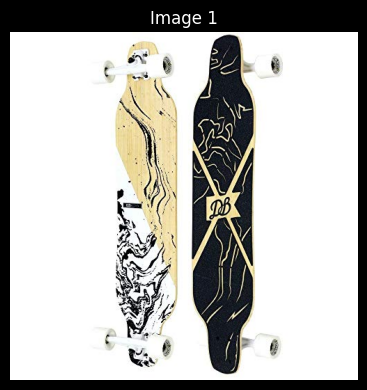

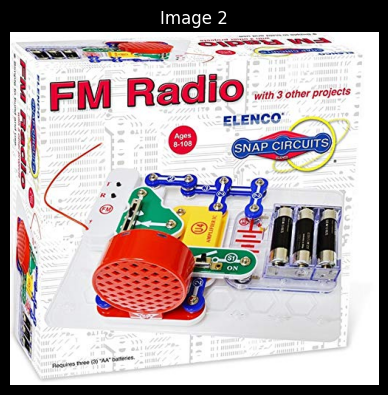

Image Query 1: Can you identify the product in this image and describe its usage?

Image 1 Response:
The db longboards coreflex crossbow 41 bamboo fiberglass longboard is designed for both beginners and experienced riders alike. It has an adjustable height of up to 4 inches, making it suitable for various riding styles. The board also comes equipped with high-quality components such as aluminum trucks, grip tape, and bearings that ensure smooth performance while providing durability over time. Additionally, its lightweight construction makes transport easy when not in use or during travel. Finally, this model offers excellent value at just under $200 USD – perfect if you’re looking for something reliable yet affordable!

Image 2 Response:
The Snap Circuits Stem Electronics Discovery Kit is an innovative STEM toy that allows children to explore the world of electronics through hands-on experimentation. This kit includes over 70 components such as resistors, capacitors, transistors, diod

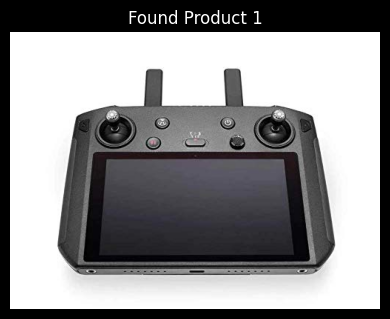


Image Search Query: Can you show me a picture of the Apple AirPods Pro?
Response: The Apple AirPods Pro is a wireless earbud that offers active noise cancellation (ANC) technology for an immersive listening experience. It has three sizes of silicone tips to ensure a comfortable fit and secure seal for optimal sound quality. With its H1 chip, it provides faster connectivity and hands-free "Hey Siri" voice control. Additionally, it has sweat and water resistance, making it suitable for workouts or outdoor activities.

Displayed Products:
Product 1:
- Name: DJI Smart Controller
- Price: $718.98

Cleaning up resources...
GPU memory cleared
Testing completed


In [6]:
# Main execution
if __name__ == "__main__":
    try:
        print("Initializing models...")
        initialize_models()
        
        print("Loading data...")
        load_data()
        
        print("Creating FAISS index...")
        text_embeddings_dict, image_embeddings_dict = load_embeddings_from_huggingface("chen196473/amazon_vector_database")
        create_faiss_indexes(text_embeddings_dict, image_embeddings_dict)
        
        print("Running test queries...")
        # Existing test queries remain the same
        text_query_1 = "What are the features of the Samsung Galaxy S21?"
        text_response_1 = chatbot(text_query_1)
        print(f"Text Query: {text_query_1}")
        print(f"Response: {text_response_1}\n")

        text_query_2 = "What are the features of the DB Longboards CoreFlex Crossbow?"
        text_response_2 = chatbot(text_query_2)
        print(f"Text Query: {text_query_2}")
        print(f"Response: {text_response_2}\n")

        text_query_3 = "Can you compare the Amazon Echo Dot with the Google Nest Mini?"
        text_response_3 = chatbot(text_query_3)
        print(f"Text Query: {text_query_3}")
        print(f"Response: {text_response_3}\n")

        # First image test with provided URLs
        image_urls_1 = [
            "https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg",
            "https://images-na.ssl-images-amazon.com/images/I/5166GD8OkXL.jpg"
        ]
        image_query_1 = "Can you identify the product in this image and describe its usage?"
        image_responses_1 = chatbot(image_query_1, image_urls_1)
        print(f"Image Query 1: {image_query_1}")
        for i, response in enumerate(image_responses_1):
            print(f"\nImage {i+1} Response:")
            print(response)

        # Test image search query
        image_search_query = "Can you show me a picture of the Apple AirPods Pro?"
        image_search_response = chatbot(image_search_query)
        print(f"\nImage Search Query: {image_search_query}")
        if isinstance(image_search_response, tuple):
            response, displayed_images = image_search_response
            print(f"Response: {response}")
            print("\nDisplayed Products:")
            for i, img_info in enumerate(displayed_images, 1):
                print(f"Product {i}:")
                print(f"- Name: {img_info['product_name']}")
                # Handle price formatting based on type
                if isinstance(img_info['price'], (int, float)):
                    print(f"- Price: ${img_info['price']:.2f}")
                else:
                    print(f"- Price: {img_info['price']}")
        else:
            print(f"Response: {image_search_response}")

    finally:
        # Clean up resources
        print("\nCleaning up resources...")
        cleanup_resources()
        print("Testing completed")

Processing query: Can you show me a picture of the db longboards?
Query type: image_search

Found matching products:


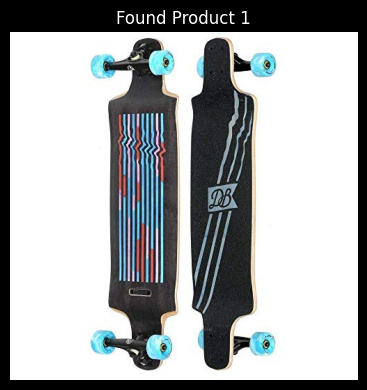


Image Search Query: Can you show me a picture of the db longboards?
Response: The db longboards is a type of longboard that has been designed for both beginners and experienced riders alike. It comes with an adjustable height so it can be customized according to your needs. This board also includes a kick tail which allows you to perform tricks such as ollies or flips easily without having any prior experience in doing them beforehand! Additionally, this model boasts high quality construction materials like aluminum alloy trucks along with polyurethane wheels making sure they last longer than other brands available today while still providing excellent performance when riding down hills at speedy rates too!

Displayed Products:
Product 1:
- Name: DB Longboards Contra Drop Deck Maple Longboard Complete
- Price: $80.96


In [8]:
        # Test image search query
        image_search_query = "Can you show me a picture of the db longboards?"
        image_search_response = chatbot(image_search_query)
        print(f"\nImage Search Query: {image_search_query}")
        if isinstance(image_search_response, tuple):
            response, displayed_images = image_search_response
            print(f"Response: {response}")
            print("\nDisplayed Products:")
            for i, img_info in enumerate(displayed_images, 1):
                print(f"Product {i}:")
                print(f"- Name: {img_info['product_name']}")
                # Handle price formatting based on type
                if isinstance(img_info['price'], (int, float)):
                    print(f"- Price: ${img_info['price']:.2f}")
                else:
                    print(f"- Price: {img_info['price']}")
        else:
            print(f"Response: {image_search_response}")